# Obtaining a dataset for region classification of Spotify Chart tracks

In this notebook, I create a dataset that could be used for training and evaluating a classifier that identifies what features are typical for a track charting in a particular region. The endresult is a dataframe with equal numbers of examples for Europe, Asia, Northern America and Latin America. Note that every track in this dataset only charted in a single region, so this is **not** a multi-label classification task.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import get_countries_charts
from helpers.model import get_basic_track_features

In [2]:
countries_charts = get_countries_charts()
countries_charts


,country,date,rank,streams,id,iso_alpha3,iso_alpha2,geo_region,geo_subregion
0,Argentina,2017-01-01,1,253019.0,6mICuAdrwEjh6Y6lroV2Kg,ARG,AR,Americas,Latin America and the Caribbean
1,Argentina,2017-01-01,2,223988.0,7DM4BPaS7uofFul3ywMe46,ARG,AR,Americas,Latin America and the Caribbean
2,Argentina,2017-01-01,3,210943.0,3AEZUABDXNtecAOSC1qTfo,ARG,AR,Americas,Latin America and the Caribbean
3,Argentina,2017-01-01,4,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,ARG,AR,Americas,Latin America and the Caribbean
4,Argentina,2017-01-01,5,153956.0,58IL315gMSTD37DOZPJ2hf,ARG,AR,Americas,Latin America and the Caribbean
...,...,...,...,...,...,...,...,...,...
4472525,Uruguay,2021-08-13,25,11431.0,4aXicRG47bBEcKXlDaSRwW,URY,UY,Americas,Latin America and the Caribbean
4472526,Uruguay,2021-08-13,27,10946.0,43qcs9NpJhDxtG91zxFkj7,URY,UY,Americas,Latin America and the Caribbean
4472527,Uruguay,2021-08-13,33,9994.0,4M4DTyLupKvbJKlE4I4EYq,URY,UY,Americas,Latin America and the Caribbean
4472528,Uruguay,2021-08-13,35,9251.0,5jzEwSyyymBlf1fa1o39T2,URY,UY,Americas,Latin America and the Caribbean


In [3]:
charting_tracks_by_region = (
    countries_charts.drop_duplicates(subset=["id", "geo_region"])[
        ["id", "geo_region"]
    ]
    .rename(columns={"geo_region": "region"})
)
charting_tracks_by_region

,id,region
0,6mICuAdrwEjh6Y6lroV2Kg,Americas
1,7DM4BPaS7uofFul3ywMe46,Americas
2,3AEZUABDXNtecAOSC1qTfo,Americas
3,6rQSrBHf7HlZjtcMZ4S4bO,Americas
4,58IL315gMSTD37DOZPJ2hf,Americas
...,...,...
4470104,4yMWMZEesltigOANqYkaWo,Americas
4470307,7exaYYNN99DHkbZuHOZWO3,Americas
4471250,39yyHtQ4tkjZzd8TfIBKQw,Americas
4472041,6ClL99PvuCeBLTFTdnR1Hw,Americas


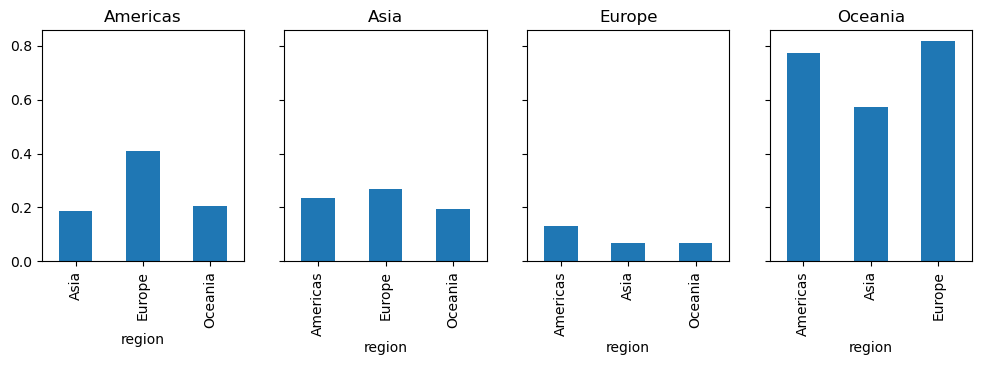

In [4]:
def plot_overlap_with_other_regions(tracks_by_region):
    df = tracks_by_region.copy()
    df["is_charting"] = True
    df = df.pivot(
        index="id", columns="region", values="is_charting"
    )
    df = df.fillna(False)

    fig, axs = plt.subplots(1, len(tracks_by_region.region.unique()), figsize=(12, 3), sharey=True)
    axs = axs.ravel()

    for i, region in enumerate(df.columns):
        ax = axs[i]
        ax.set_title(region)
        tracks_charting_in_region = df.loc[df[region] == True]
        no_tracks_charting_in_other_regions_too = tracks_charting_in_region.loc[:, df.columns != region].sum()
        perc_tracks_charting_in_other_regions = no_tracks_charting_in_other_regions_too / tracks_charting_in_region.shape[0]
        #perc_tracks_charting_in_other_regions.index = perc_tracks_charting_in_other_regions.index.remove_unused_categories()
        perc_tracks_charting_in_other_regions.plot.bar(ax=ax)


plot_overlap_with_other_regions(charting_tracks_by_region)

In [5]:
tracks_charting_only_in_one_region = charting_tracks_by_region[~charting_tracks_by_region.duplicated(keep=False, subset=["id"])].reset_index(drop=True)
tracks_charting_only_in_one_region

,id,region
0,1MpKZi1zTXpERKwxmOu1PH,Americas
1,1pWYnQIlqxTh5bxuPmTG4E,Americas
2,7IRuf7FrdQvOGs0g9mSNGr,Americas
3,3gEebOzxHpEwElicl1XBy0,Americas
4,0tGAPnTFwRJA6FZgYZ0BAe,Americas
...,...,...
30099,4PDoCa5P0QK7KFhTsEKJB8,Americas
30100,4yMWMZEesltigOANqYkaWo,Americas
30101,7exaYYNN99DHkbZuHOZWO3,Americas
30102,6ClL99PvuCeBLTFTdnR1Hw,Americas


## Combining track IDs per (sub-)region with features

In [6]:
track_feats = get_basic_track_features()
track_feats

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release
id,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.13100,0.000000,0.0852,0.524,120.963,188491.0,4.0,True
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False


### Regions

In [7]:
region_tracks_features = pd.merge(track_feats, tracks_charting_only_in_one_region, on="id").set_index("id")
region_tracks_features

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False,Asia
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas


<AxesSubplot:xlabel='region', ylabel='count'>

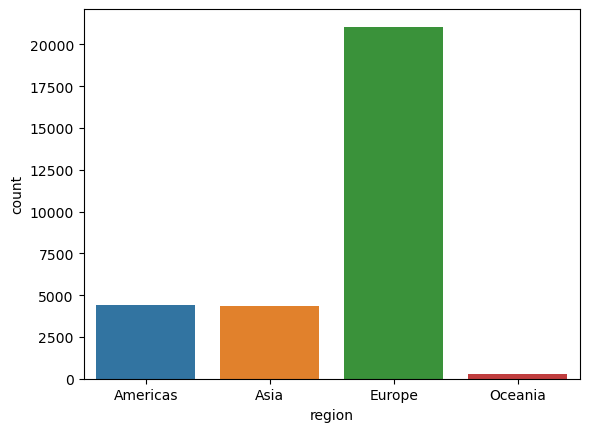

In [8]:
sns.countplot(data=region_tracks_features, x="region")

#### Removing region with too little training examples

We have too little examples from Oceania to train a classifier in a meaningful way. So, better remove that category entirely.

In [9]:
region_tracks_features

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False,Asia
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas


In [10]:
region_track_feats_dataset = region_tracks_features.copy().loc[region_tracks_features.region != "Oceania"]
region_track_feats_dataset.region = region_track_feats_dataset.region.cat.remove_unused_categories()
region_track_feats_dataset

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False,Asia
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas


<AxesSubplot:xlabel='region', ylabel='count'>

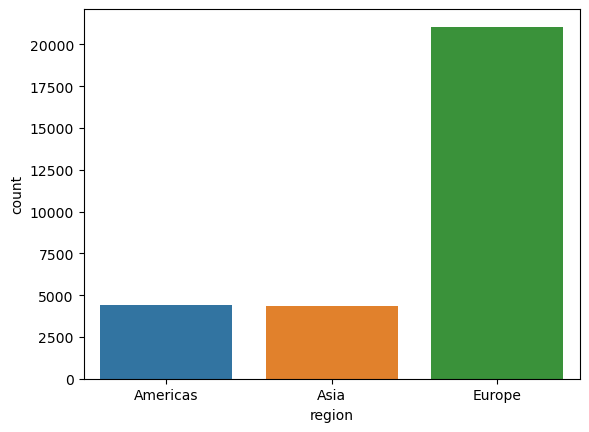

In [11]:
sns.countplot(data=region_track_feats_dataset, x="region")

In [12]:
charting_tracks_by_region.groupby('id').size().value_counts()

1    30104
2     1947
4     1104
3      725
dtype: int64

In [13]:
region_track_feats_dataset.groupby(["id"]).size().value_counts()

1    29794
dtype: int64

In [14]:
region_track_feats_dataset

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False,Asia
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas


In [15]:
from helpers.model import get_track_feature_region_dataset

all(region_track_feats_dataset == get_track_feature_region_dataset())

True

In [16]:
region_track_feats_dataset

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe
7zyYmIdjqqiX6kLryb7QBx,False,0.423,0.360,3.0,-9.458,1.0,0.0372,0.72800,0.000000,0.1050,0.291,130.576,260573.0,4.0,False,Asia
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas


#### Looking for differences in feature distribution by region

In [17]:
from sklearn.preprocessing import MinMaxScaler

track_feat_cols = track_feats.columns
def min_max_scale_track_features(track_feature_dataset):
    df = track_feature_dataset.copy()
    scaler = MinMaxScaler()
    df[track_feat_cols] = scaler.fit_transform(df[track_feat_cols])
    return df

In [18]:
region_track_feats_minmax_scaled = min_max_scale_track_features(region_track_feats_dataset)

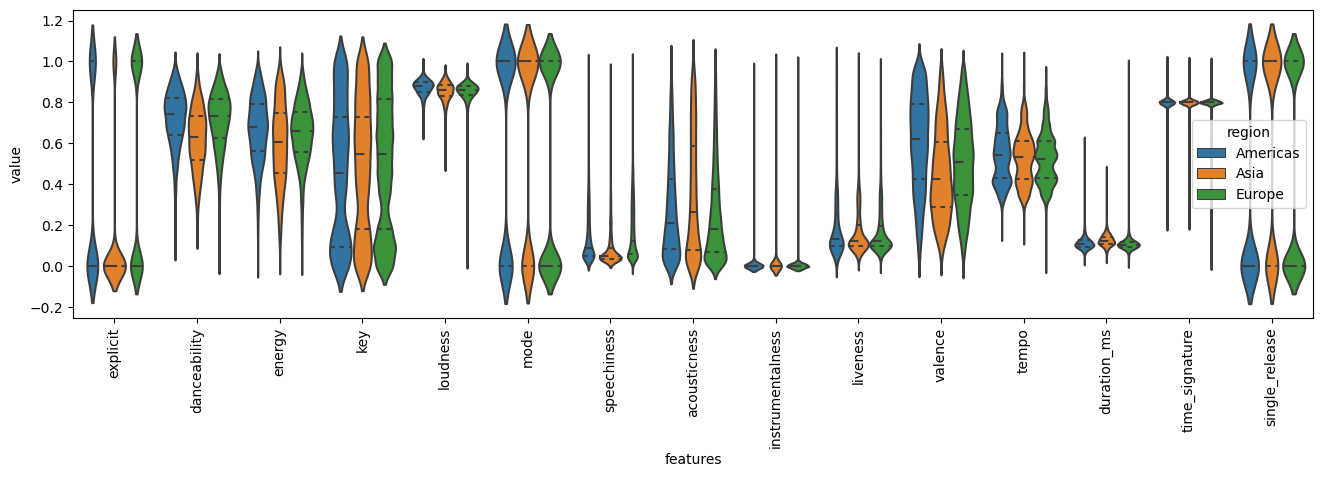

In [19]:
data = pd.melt(region_track_feats_minmax_scaled,
                   id_vars="region",
                   var_name="features",
                   value_name='value')

plt.figure(figsize=(16, 4))
sns.violinplot(x="features", y="value", data=data,
                   hue="region",# compare distributions of values for feature by class (different colors for each of the two classes)
                   #split=True,# split violins (left half distribution of false class, right shows distribution of true)
                   inner="quartile"# show quartiles as lines instead of putting boxplot inside
                   )
plt.xticks(rotation=90)
plt.show()

## Analyzing data by subregion

In [20]:
charting_tracks_by_subregion = (
    countries_charts.drop_duplicates(subset=["id", "geo_subregion"])[
        ["id", "geo_region", "geo_subregion"]
    ]
    .rename(columns={"geo_region": "region", "geo_subregion": "subregion"})
)
charting_tracks_by_subregion

,id,region,subregion
0,6mICuAdrwEjh6Y6lroV2Kg,Americas,Latin America and the Caribbean
1,7DM4BPaS7uofFul3ywMe46,Americas,Latin America and the Caribbean
2,3AEZUABDXNtecAOSC1qTfo,Americas,Latin America and the Caribbean
3,6rQSrBHf7HlZjtcMZ4S4bO,Americas,Latin America and the Caribbean
4,58IL315gMSTD37DOZPJ2hf,Americas,Latin America and the Caribbean
...,...,...,...
4470104,4yMWMZEesltigOANqYkaWo,Americas,Latin America and the Caribbean
4470307,7exaYYNN99DHkbZuHOZWO3,Americas,Latin America and the Caribbean
4471250,39yyHtQ4tkjZzd8TfIBKQw,Americas,Latin America and the Caribbean
4472041,6ClL99PvuCeBLTFTdnR1Hw,Americas,Latin America and the Caribbean


subregion,Australia and New Zealand,Eastern Asia,Eastern Europe,Latin America and the Caribbean,Northern America,Northern Europe,South-eastern Asia,Southern Europe,Western Asia,Western Europe
id,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,False,False,True,False,False,False,False,False,False
000xQL6tZNLJzIrtIgxqSl,True,True,True,False,True,True,True,True,False,True
000xYdQfIZ4pDmBGzQalKU,False,False,False,True,False,False,False,False,False,False
001b8t3bYPfnabpjpfG1Y4,False,False,False,False,False,False,False,False,False,True
003VDDA7J3Xb2ZFlNx7nIZ,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
7zxphfIdUMOfZOAVpKFlld,False,False,False,False,False,True,False,False,False,False
7zyYmIdjqqiX6kLryb7QBx,False,True,False,False,False,False,True,False,False,False
7zyZ9yPXIQebb79PrMghpV,False,False,False,True,False,False,False,False,False,False


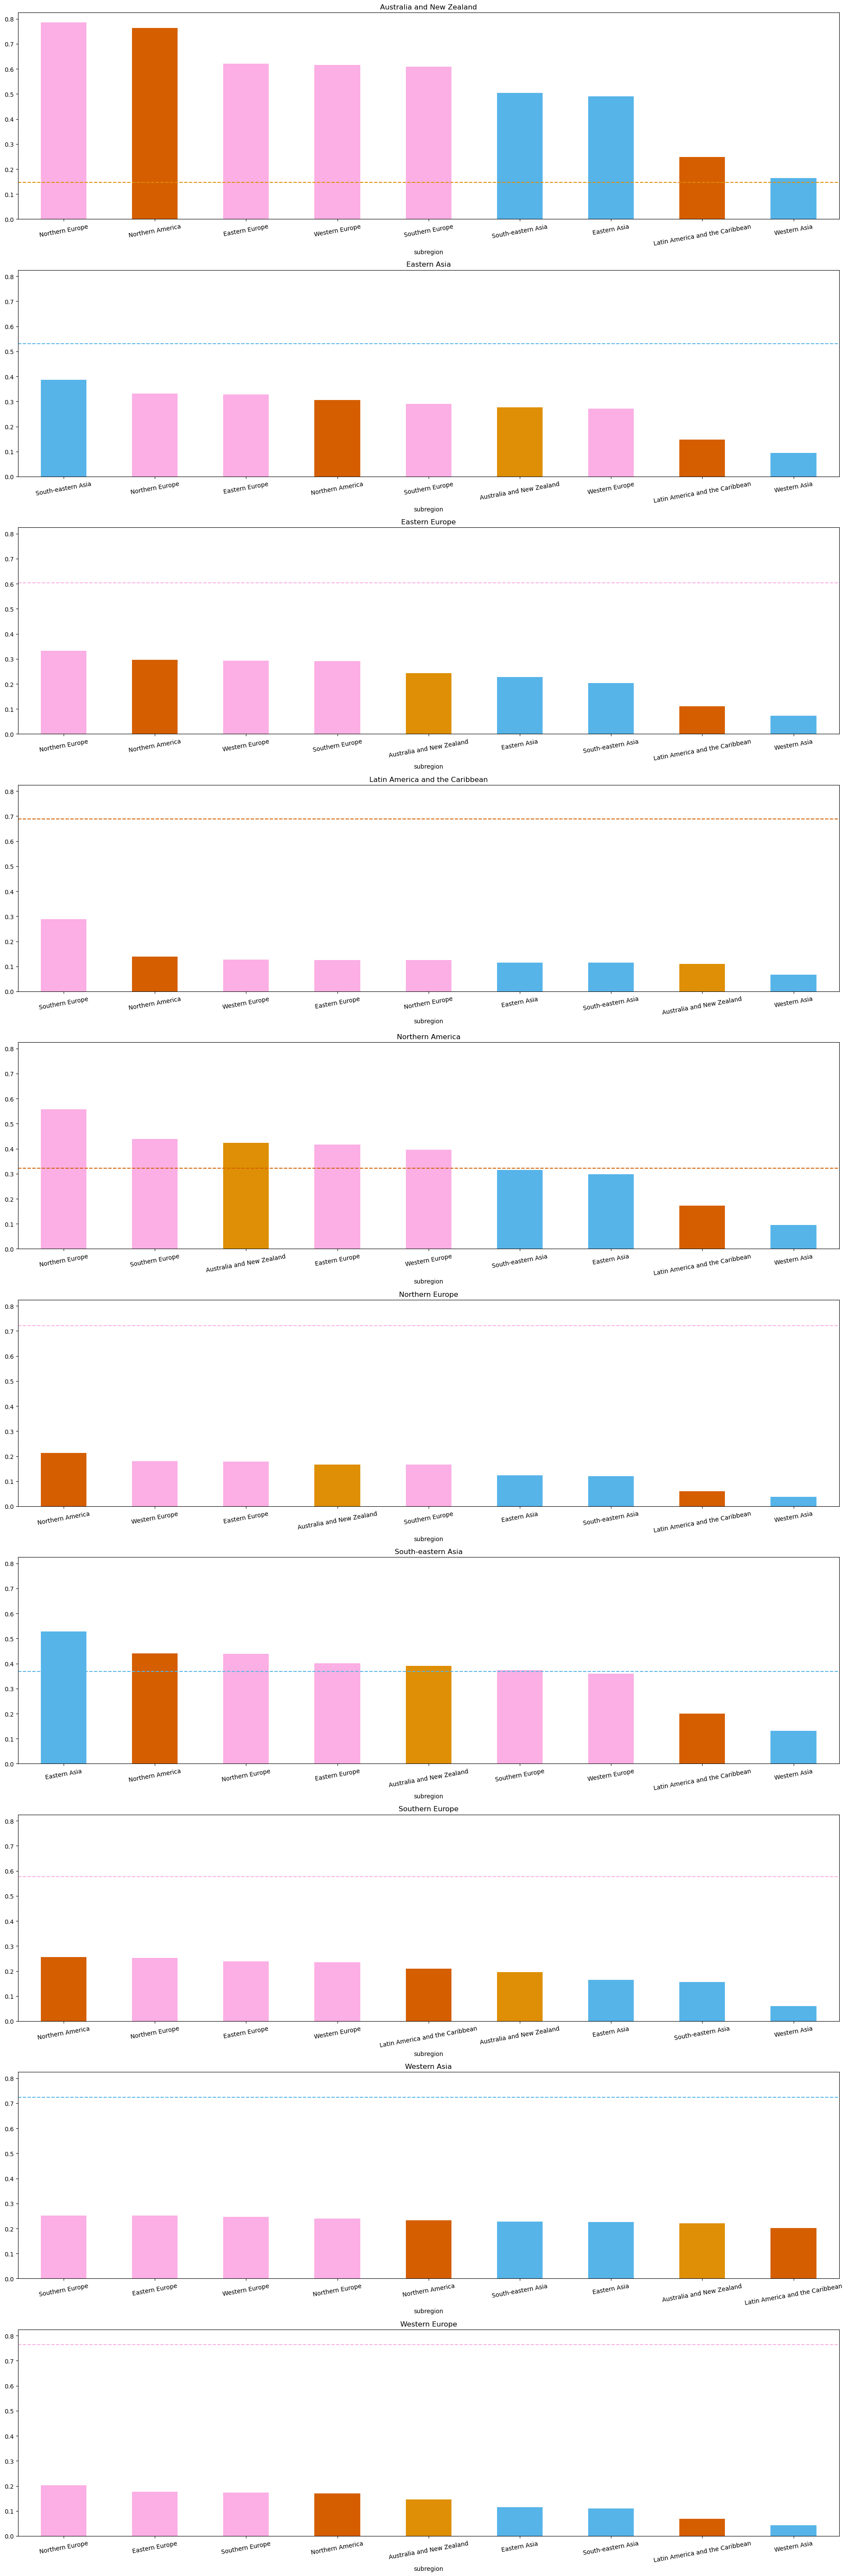

In [21]:
def plot_overlap_with_other_subregions(tracks_by_subregion):
    df = tracks_by_subregion.copy()
    df["is_charting"] = True
    df = df.pivot(index="id", columns="subregion", values="is_charting")
    df = df.fillna(False)
    display(df)

    subregion_count = len(tracks_by_subregion.subregion.unique())
    fig, axs = plt.subplots(
        subregion_count, 1, figsize=(20, subregion_count * 6), sharey=True
    )
    axs = axs.ravel()
    subregion_to_region = tracks_by_subregion.set_index("subregion")["region"].to_dict()
    color_palette = sns.color_palette("colorblind")
    region_to_color = {
        region: color
        for region, color in zip(subregion_to_region.values(), color_palette)
    }

    def get_color_for_subregion(subregion):
        region = subregion_to_region[subregion]
        return region_to_color[region]

    for i, subregion in enumerate(df.columns):
        ax = axs[i]
        ax.set_title(subregion)
        tracks_charting_in_subregion = df.loc[df[subregion] == True]
        no_tracks_charting_in_other_subregions_too = (
            tracks_charting_in_subregion.loc[:, df.columns != subregion]
            .sum()
            .sort_values(ascending=False)
        )
        perc_tracks_charting_in_other_subregions = (
            no_tracks_charting_in_other_subregions_too
            / tracks_charting_in_subregion.shape[0]
        )
        perc_tracks_charting_in_other_subregions.plot.bar(
            ax=ax,
            color=[
                get_color_for_subregion(subregion)
                for subregion in perc_tracks_charting_in_other_subregions.index
            ],
        )
        number_of_other_charting_countries_per_track = tracks_charting_in_subregion.loc[
            :, df.columns != subregion
        ].sum(axis=1)
        perc_tracks_charting_only_in_subregion = (
            number_of_other_charting_countries_per_track.loc[
                number_of_other_charting_countries_per_track == 0
            ].shape[0]
            / tracks_charting_in_subregion.shape[0]
        )
        ax.axhline(
            perc_tracks_charting_only_in_subregion,
            color=get_color_for_subregion(subregion),
            linestyle="--",
        )
        ax.tick_params(axis="x", rotation=10)

    plt.tight_layout()


plot_overlap_with_other_subregions(charting_tracks_by_subregion)


In [22]:
charting_tracks_by_subregion.groupby('id').size().value_counts()

1     29389
2      1792
3       625
4       450
8       345
5       327
6       287
10      241
9       216
7       208
dtype: int64

In [23]:
tracks_charting_only_in_one_subregion = charting_tracks_by_subregion[~charting_tracks_by_subregion.duplicated(keep=False, subset="id")].reset_index(drop=True)
tracks_charting_only_in_one_subregion

,id,region,subregion
0,1MpKZi1zTXpERKwxmOu1PH,Americas,Latin America and the Caribbean
1,1pWYnQIlqxTh5bxuPmTG4E,Americas,Latin America and the Caribbean
2,7IRuf7FrdQvOGs0g9mSNGr,Americas,Latin America and the Caribbean
3,3gEebOzxHpEwElicl1XBy0,Americas,Latin America and the Caribbean
4,0tGAPnTFwRJA6FZgYZ0BAe,Americas,Latin America and the Caribbean
...,...,...,...
29384,4PDoCa5P0QK7KFhTsEKJB8,Americas,Latin America and the Caribbean
29385,4yMWMZEesltigOANqYkaWo,Americas,Latin America and the Caribbean
29386,7exaYYNN99DHkbZuHOZWO3,Americas,Latin America and the Caribbean
29387,6ClL99PvuCeBLTFTdnR1Hw,Americas,Latin America and the Caribbean


In [24]:
# verify that we calculated makes sense
tracks_charting_only_in_one_subregion.groupby("id").subregion.count().value_counts()

1    29389
Name: subregion, dtype: int64

In [25]:
subregion_tracks_features = pd.merge(
        track_feats, tracks_charting_only_in_one_subregion, on="id"
    ).set_index("id")

In [26]:
subregion_tracks_features

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region,subregion
id,,,,,,,,,,,,,,,,,
000RW47rhEkSqjgTrZx7YX,False,0.752,0.620,5.0,-5.536,1.0,0.0509,0.30900,0.000000,0.0750,0.962,117.399,164459.0,4.0,False,Americas,Latin America and the Caribbean
000xYdQfIZ4pDmBGzQalKU,False,0.509,0.803,0.0,-6.743,1.0,0.0400,0.68400,0.000539,0.4630,0.651,166.018,187119.0,4.0,False,Americas,Latin America and the Caribbean
001b8t3bYPfnabpjpfG1Y4,True,0.772,0.635,9.0,-4.846,1.0,0.3720,0.10500,0.000000,0.1170,0.541,95.951,167866.0,4.0,False,Europe,Western Europe
003VDDA7J3Xb2ZFlNx7nIZ,True,0.842,0.578,6.0,-6.050,0.0,0.1380,0.00419,0.000000,0.2280,0.190,74.496,236779.0,4.0,True,Americas,Northern America
004zGvrc84enQHFitC6auy,True,0.730,0.696,2.0,-7.173,1.0,0.3550,0.17500,0.000020,0.3210,0.584,172.040,184186.0,4.0,False,Europe,Southern Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zxRMhXxJMQCeDDg0rKAVo,True,0.744,0.715,0.0,-6.103,1.0,0.3510,0.10100,0.000000,0.0919,0.340,154.962,179773.0,4.0,False,Americas,Northern America
7zxphfIdUMOfZOAVpKFlld,True,0.725,0.453,6.0,-11.291,0.0,0.3160,0.00582,0.013500,0.0827,0.461,121.913,110164.0,4.0,True,Europe,Northern Europe
7zyZ9yPXIQebb79PrMghpV,False,0.596,0.864,8.0,-3.850,1.0,0.0400,0.08580,0.000000,0.1580,0.833,169.123,167503.0,4.0,False,Americas,Latin America and the Caribbean


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Australia and New Zealand'),
  Text(1, 0, 'Eastern Asia'),
  Text(2, 0, 'Eastern Europe'),
  Text(3, 0, 'Latin America and the Caribbean'),
  Text(4, 0, 'Northern America'),
  Text(5, 0, 'Northern Europe'),
  Text(6, 0, 'South-eastern Asia'),
  Text(7, 0, 'Southern Europe'),
  Text(8, 0, 'Western Asia'),
  Text(9, 0, 'Western Europe')])

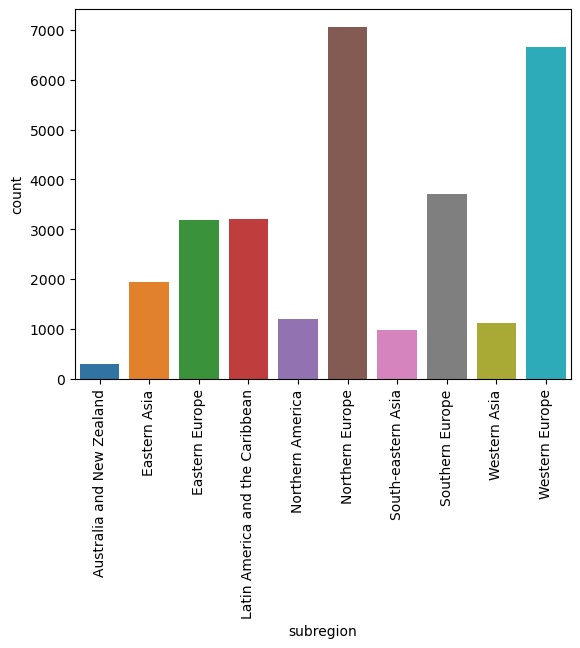

In [27]:
sns.countplot(subregion_tracks_features, x="subregion")
plt.xticks(rotation=90)

In [28]:
subregion_track_feats_minmax_scaled = min_max_scale_track_features(subregion_tracks_features)

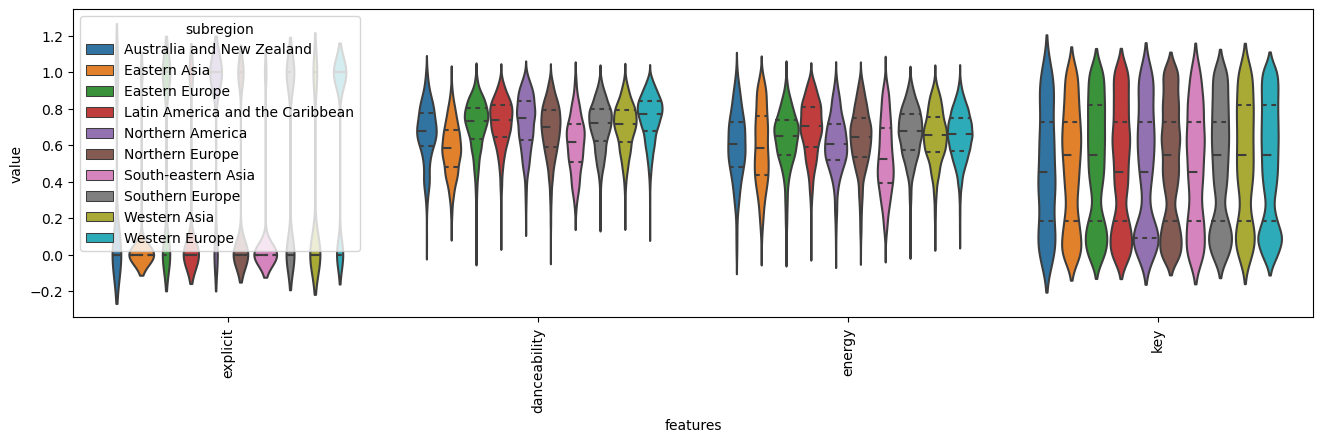

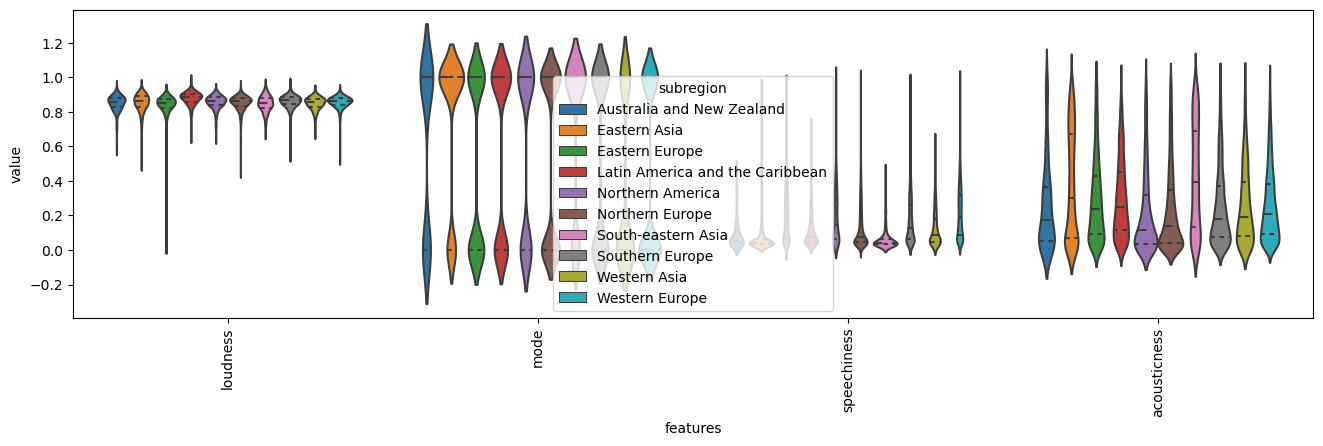

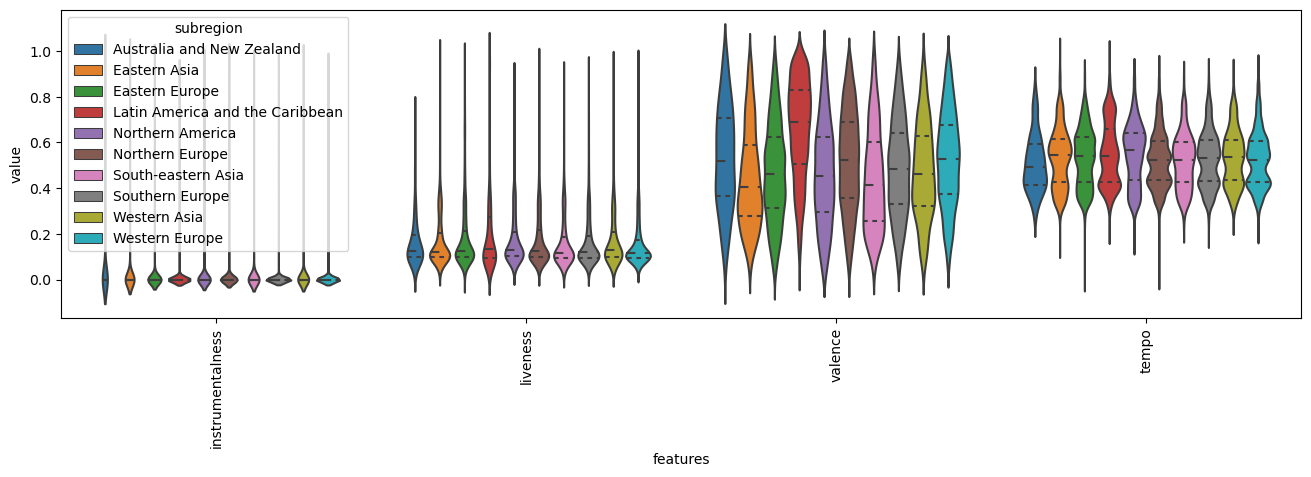

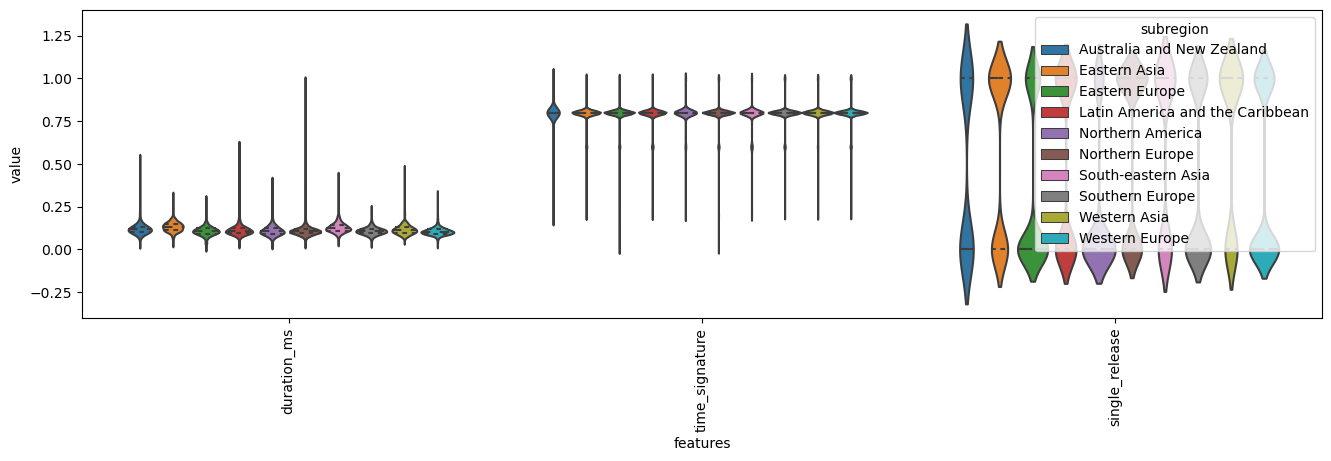

In [29]:
data = pd.melt(subregion_track_feats_minmax_scaled.drop(columns="region"),
                   id_vars="subregion",
                   var_name="features",
                   value_name='value')

features_per_figure = 4
i = 0
while i < len(track_feat_cols):
    plt.figure(figsize=(16, 4))
    sns.violinplot(x="features", y="value", data=data.loc[data.features.isin(track_feat_cols[i:i+features_per_figure])],
                   hue="subregion",# compare distributions of values for feature by class (different colors for each of the two classes)
                   #split=True,# split violins (left half distribution of false class, right shows distribution of true)
                   inner="quartile"# show quartiles as lines instead of putting boxplot inside
                   )
    plt.xticks(rotation=90)
    i += features_per_figure

plt.show()

## Data by country

In [30]:
charting_tracks_by_country = (
    countries_charts.drop_duplicates(subset=["id", "country"])[
        ["id", "country", "geo_region", "geo_subregion"]
    ]
    .rename(columns={"geo_region": "region", "geo_subregion": "subregion"})
)
charting_tracks_by_country

,id,country,region,subregion
0,6mICuAdrwEjh6Y6lroV2Kg,Argentina,Americas,Latin America and the Caribbean
1,7DM4BPaS7uofFul3ywMe46,Argentina,Americas,Latin America and the Caribbean
2,3AEZUABDXNtecAOSC1qTfo,Argentina,Americas,Latin America and the Caribbean
3,6rQSrBHf7HlZjtcMZ4S4bO,Argentina,Americas,Latin America and the Caribbean
4,58IL315gMSTD37DOZPJ2hf,Argentina,Americas,Latin America and the Caribbean
...,...,...,...,...
4472058,1sZ39ZxvFo8FyMz4s7iVlf,Uruguay,Americas,Latin America and the Caribbean
4472108,7hiAGGyiLaLBTVroaE08hx,Uruguay,Americas,Latin America and the Caribbean
4472157,5W1qmxHrMlQGGAiFA3ZQqP,Uruguay,Americas,Latin America and the Caribbean
4472208,7rglLriMNBPAyuJOMGwi39,Uruguay,Americas,Latin America and the Caribbean


In [31]:
charting_tracks_by_country.groupby('country').size().sort_values(ascending = False)

country
Switzerland           3414
United States         3394
France                3391
Germany               3181
Finland               2968
Austria               2823
Slovakia              2820
Canada                2805
Italy                 2781
Sweden                2718
Iceland               2669
Netherlands           2549
Greece                2493
Denmark               2475
United Kingdom        2460
Poland                2404
Czech Republic        2377
Belgium               2187
Norway                2121
Taiwan                2098
Hong Kong             2093
Ireland               2068
Hungary               1920
Australia             1791
New Zealand           1742
Malaysia              1722
Singapore             1688
Portugal              1646
Turkey                1537
Dominican Republic    1432
Spain                 1361
Brazil                1341
Panama                1305
Philippines           1292
Indonesia             1193
Mexico                1170
Costa Rica          

In [32]:
countries_charts.groupby("geo_region").streams.sum().sort_values(ascending = False)

geo_region
Americas    1.641368e+11
Europe      1.256232e+11
Asia        3.667009e+10
Oceania     1.227340e+10
Name: streams, dtype: float64

In [33]:
streams_per_country = countries_charts.groupby("country").streams.sum().sort_values(ascending = False)
streams_per_country

country
United States         6.664872e+10
Brazil                2.776871e+10
Mexico                2.287400e+10
Germany               2.077738e+10
United Kingdom        1.897820e+10
Spain                 1.547413e+10
Italy                 1.358924e+10
France                1.168422e+10
Argentina             1.104077e+10
Australia             1.019892e+10
Netherlands           1.018208e+10
Philippines           1.010755e+10
Chile                 9.869191e+09
Canada                9.327649e+09
Indonesia             8.255808e+09
Sweden                8.015910e+09
Turkey                6.406908e+09
Japan                 5.507563e+09
Norway                4.880355e+09
Peru                  4.527544e+09
Poland                4.300430e+09
Denmark               3.565919e+09
Colombia              3.407812e+09
Finland               2.654623e+09
Ireland               2.209751e+09
New Zealand           2.074481e+09
Malaysia              2.043456e+09
Belgium               2.013845e+09
Singapore   

In [34]:
from helpers import get_country_data
country_data = get_country_data().rename(columns={"geo_subregion": "subregion", "geo_region": "region"})
country_data.index.name = "country"

In [35]:
countries_with_subregion_and_streams = country_data[["subregion"]].join(streams_per_country)
countries_with_subregion_and_streams

,subregion,streams
country,,
Argentina,Latin America and the Caribbean,1.104077e+10
Australia,Australia and New Zealand,1.019892e+10
Austria,Western Europe,1.326314e+09
Belgium,Western Europe,2.013845e+09
Brazil,Latin America and the Caribbean,2.776871e+10
Canada,Northern America,9.327649e+09
Chile,Latin America and the Caribbean,9.869191e+09
Colombia,Latin America and the Caribbean,3.407812e+09
Costa Rica,Latin America and the Caribbean,1.130278e+09


In [38]:
country_idx_biggest_market_per_subregion = countries_with_subregion_and_streams.groupby(['subregion']).streams.transform(max) == countries_with_subregion_and_streams.streams

In [56]:
countries_with_most_streams_by_subregion = countries_with_subregion_and_streams[country_idx_biggest_market_per_subregion].reset_index()
countries_with_most_streams_by_subregion

,country,subregion,streams
0,Australia,Australia and New Zealand,1.019892e+10
1,Brazil,Latin America and the Caribbean,2.776871e+10
2,Germany,Western Europe,2.077738e+10
3,Japan,Eastern Asia,5.507563e+09
4,Philippines,South-eastern Asia,1.010755e+10
5,Poland,Eastern Europe,4.300430e+09
6,Spain,Southern Europe,1.547413e+10
7,Turkey,Western Asia,6.406908e+09
8,United Kingdom,Northern Europe,1.897820e+10
9,United States,Northern America,6.664872e+10


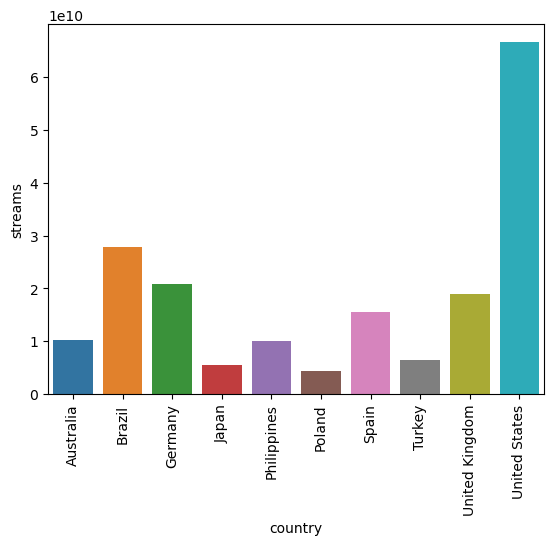

In [62]:
sns.barplot(countries_with_most_streams_by_subregion, x="country", y="streams")
plt.xticks(rotation=90)
plt.show()

In [66]:
chart_tracks_largest_country_market_by_subregion = charting_tracks_by_country.set_index("country").loc[country_idx_biggest_market_per_subregion]
chart_tracks_largest_country_market_by_subregion

,id,region,subregion
country,,,
Australia,5aAx2yezTd8zXrkmtKl66Z,Oceania,Australia and New Zealand
Australia,5knuzwU65gJK7IF5yJsuaW,Oceania,Australia and New Zealand
Australia,7BKLCZ1jbUBVqRi2FVlTVw,Oceania,Australia and New Zealand
Australia,3NdDpSvN911VPGivFlV5d0,Oceania,Australia and New Zealand
Australia,78rIJddV4X0HkNAInEcYde,Oceania,Australia and New Zealand
...,...,...,...
United States,7ACW7VpgoKmfM1sKo15UhX,Americas,Northern America
United States,2AaJeBEq3WLcfFW1y8svDf,Americas,Northern America
United States,20on25jryn53hWghthWWW3,Americas,Northern America


In [72]:
country_tracks_dataset = chart_tracks_largest_country_market_by_subregion.reset_index()

In [84]:
tracks_charting_only_in_one_country = country_tracks_dataset[
    country_tracks_dataset.duplicated(keep=False, subset="id")
]

<AxesSubplot:xlabel='country'>

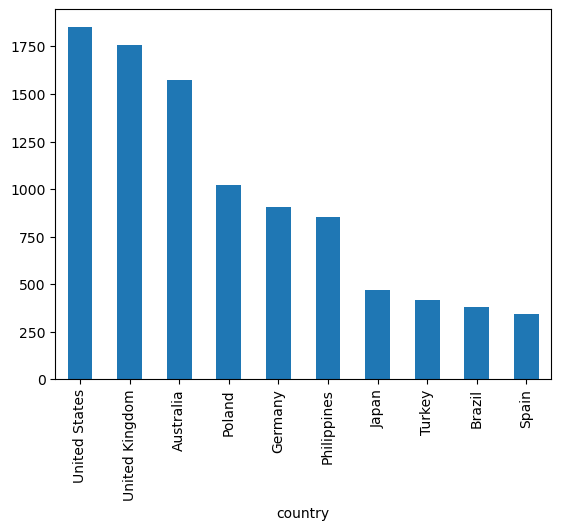

In [85]:
tracks_charting_only_in_one_country.groupby("country").size().sort_values(ascending=False).plot.bar()


In [104]:
country_track_features = pd.merge(
        track_feats, tracks_charting_only_in_one_country, on="id"
    ).set_index("id")

In [105]:
country_track_features

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,country,region,subregion
id,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.1310,0.0,0.0852,0.524,120.963,188491.0,4.0,True,Australia,Oceania,Australia and New Zealand
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.1310,0.0,0.0852,0.524,120.963,188491.0,4.0,True,Japan,Asia,Eastern Asia
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.1310,0.0,0.0852,0.524,120.963,188491.0,4.0,True,Philippines,Asia,South-eastern Asia
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.1310,0.0,0.0852,0.524,120.963,188491.0,4.0,True,Poland,Europe,Eastern Europe
000xQL6tZNLJzIrtIgxqSl,False,0.748,0.627,7.0,-6.029,1.0,0.0639,0.1310,0.0,0.0852,0.524,120.963,188491.0,4.0,True,United Kingdom,Europe,Northern Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zgqtptZvhf8GEmdsM2vp2,False,0.615,0.779,2.0,-6.454,1.0,0.1350,0.0665,0.0,0.1550,0.453,160.000,208198.0,4.0,True,Philippines,Asia,South-eastern Asia
7zgqtptZvhf8GEmdsM2vp2,False,0.615,0.779,2.0,-6.454,1.0,0.1350,0.0665,0.0,0.1550,0.453,160.000,208198.0,4.0,True,Poland,Europe,Eastern Europe
7zgqtptZvhf8GEmdsM2vp2,False,0.615,0.779,2.0,-6.454,1.0,0.1350,0.0665,0.0,0.1550,0.453,160.000,208198.0,4.0,True,Turkey,Asia,Western Asia


In [ ]:
def std_scale_track_features(track_feats):
  StandardScaler().fit_transform(track_feats[track_feat_cols])

In [106]:
country_track_feats_minmax_scaled = min_max_scale_track_features(country_track_features)

In [107]:
country_track_feats_minmax_scaled.columns

Index(['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'single_release',
       'country', 'region', 'subregion'],
      dtype='object')

,country,features,value
0,Australia,explicit,0.0
1,Japan,explicit,0.0
2,Philippines,explicit,0.0
3,Poland,explicit,0.0
4,United Kingdom,explicit,0.0
...,...,...,...
143515,Philippines,single_release,1.0
143516,Poland,single_release,1.0
143517,Turkey,single_release,1.0
143518,United Kingdom,single_release,1.0


country      object
features     object
value       float64
dtype: object


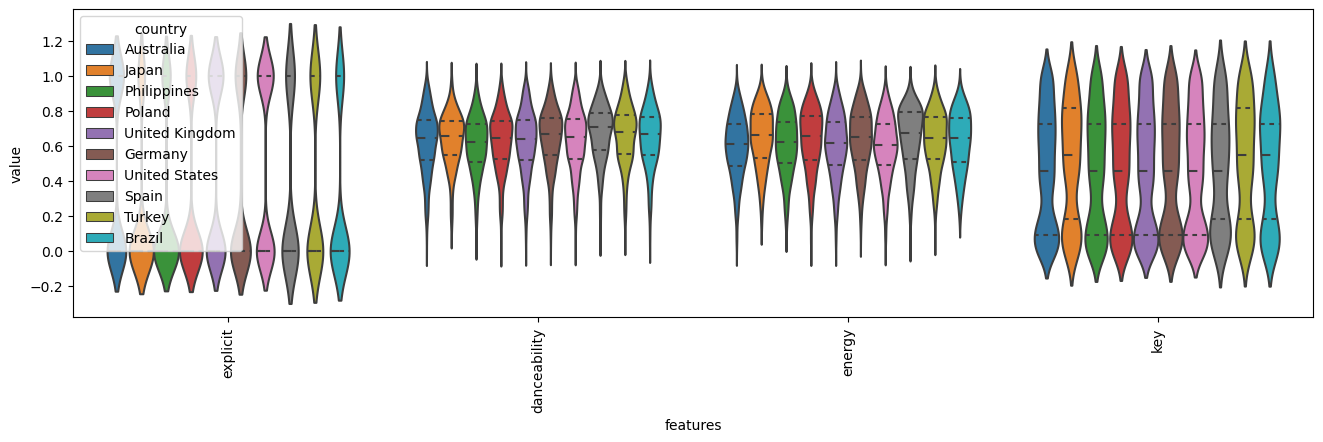

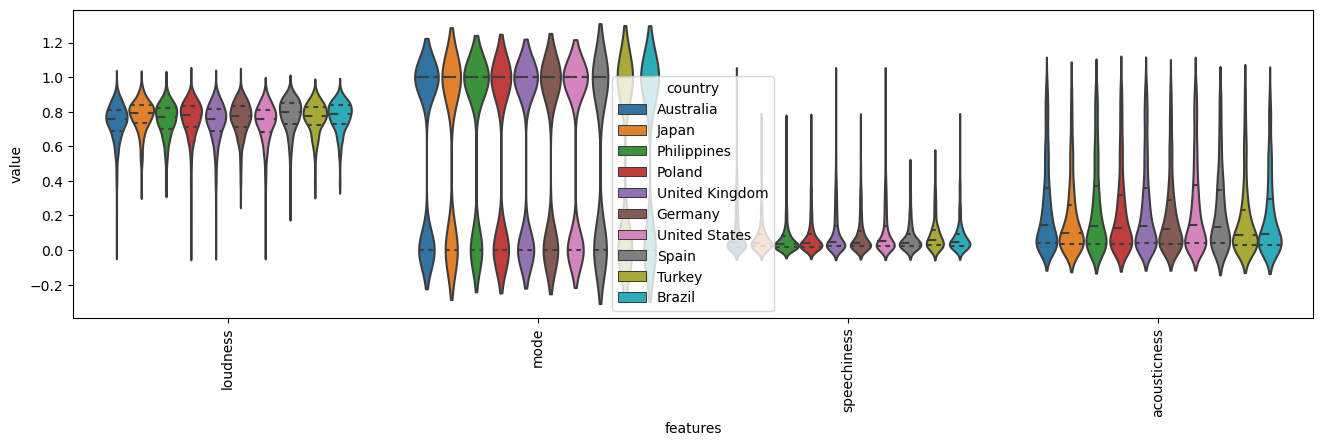

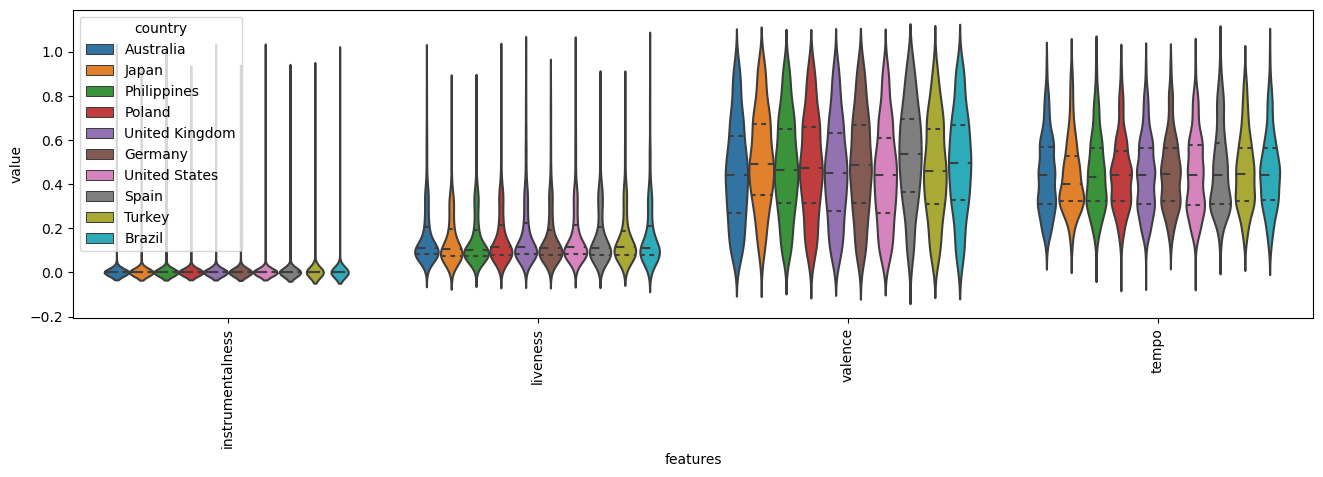

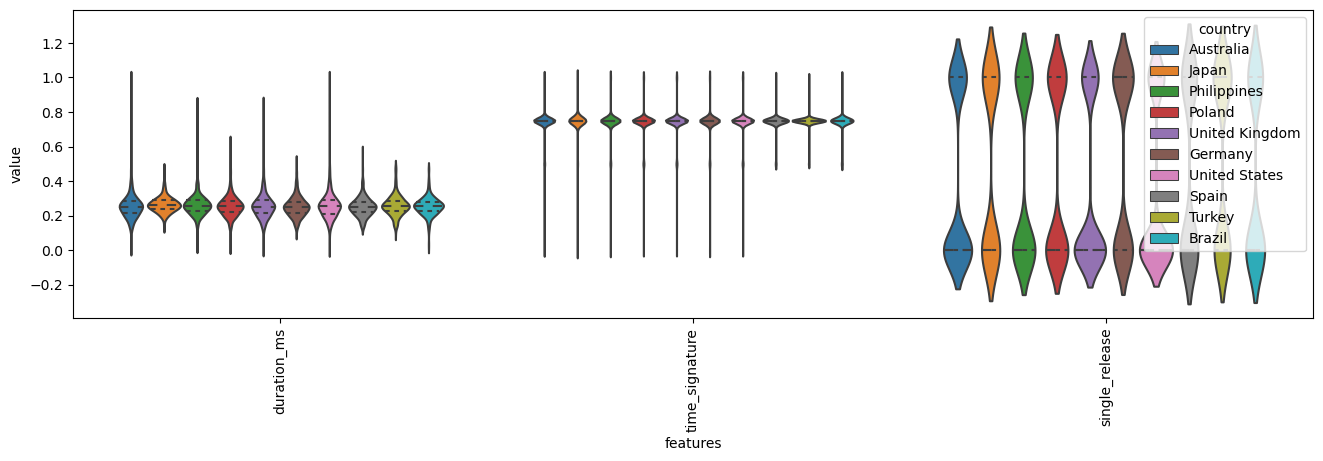

In [111]:
data = pd.melt(country_track_feats_minmax_scaled.drop(columns=["region", "subregion"]),
                   id_vars="country",
                   var_name="features",
                   value_name='value')

display(data)
print(data.dtypes)

features_per_figure = 4
i = 0
while i < len(track_feat_cols):
    plt.figure(figsize=(16, 4))
    sns.violinplot(x="features", y="value", data=data.loc[data.features.isin(track_feat_cols[i:i+features_per_figure])],
                   hue="country",# compare distributions of values for feature by class (different colors for each of the two classes)
                   #split=True,# split violins (left half distribution of false class, right shows distribution of true)
                   inner="quartile"# show quartiles as lines instead of putting boxplot inside
                   )
    plt.xticks(rotation=90)
    i += features_per_figure

plt.show()